In [78]:
'''
TO DO LIST:
1. Add function to convert between Hall mobility, Hall carrier concentration, and Hall factor
2. Mulitple Compounds Plot 
'''
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import pandas as pd
import sys
import os

In [79]:
kB = 1.38e-23 # V / K
h = 6.626e-34 # J * s
hbar = 1.054e-34 # J * s

e = 1.602e-19 # C
me = 9.11e-31 # kg
Na = 6.02e23 # /mol

In [80]:
def read_STD2(fpath : str):
    df = pd.read_csv(fpath)
    return df


In [81]:
def reduced_df_by_sample(full_df, composition: str):
    comp_df = full_df.loc[full_df['composition'] == composition]
    return comp_df


In [82]:
def add_weighted_mobility(comp_df):
    S = comp_df['Seebeck coefficient'] #units of V/K
    rho = comp_df['Electrical resistivity'] #units of Ohm*m
    sigma = comp_df['Electrical conductivity']
    T = comp_df['Temperature'] #units of K
    rat = kB / e
    aS = np.abs(S)
    muW = 331 * (1e-5 / rho) * (T / 300)**(-3 / 2) * (np.exp(aS/rat - 2)\
                 /(1 + np.exp(-5 * (aS/rat -1))) + 3 * aS / (pi**2 * rat)\
                 /(1 + np.exp(5 * (aS/rat -1)))) 
    comp_df['Weighted mobility'] = muW
    return comp_df


In [83]:
def add_effective_mass(comp_df):
    S = comp_df['Seebeck coefficient'] #units of V/K
    rho = comp_df['Electrical resistivity'] #units of Ohm*m
    sigma = comp_df['Electrical conductivity']
    T = comp_df['Temperature'] #units of K
    nH = comp_df['Carrier concentration']
    rat = kB / e
    aS = np.abs(S)
    muS = (h**2/(2*kB*T))*(3*nH/16*pi**.5)**(2/3)* ((np.exp(aS/rat - 2)-0.17)**(2/3)\
                 /(1 + np.exp(-5 * (aS/rat -1))) + (3/pi**2)*(2/pi**0.5)**(2/3) * aS / (pi**2 * rat)\
                 /(1 + np.exp(5 * (aS/rat -1)))) 
    comp_df['Seebeck Effective Mass'] = muS/me
    return comp_df

In [166]:
def convert_hall_data(comp_df):
    # If carrier concentration doesn't exist and mobility exists, calculate carrier concentration
    if ( np.isnan(comp_df['Carrier concentration']).any() ) and ( not np.isnan(comp_df['Carrier mobility']).any() ):
        Rh = comp_df['Carrier mobility'].to_numpy() * comp_df['Electrical resistivity'].to_numpy()
        nh = (Rh * e) ** -1
        comp_df['Carrier concentration'] = nh
    
    # If mobility doesn't exist and carrier concentration exists, calculate mobility
    elif ( not np.isnan(comp_df['Carrier concentration']).any() ) and ( np.isnan(comp_df['Carrier mobility']).any() ):
        comp_df['Carrier mobility'] = (comp_df['Carrier concentration'].to_numpy() * comp_df['Electrical resistivity'].to_numpy() * e )**(-1)
    
    return comp_df

In [85]:
def split_sampleid(comp_df):
    sid = comp_df['sampleid'].to_numpy()
    unique_sampleid, sampleid_counts = np.unique(sid, return_counts=True)
    data = {}
    for sampleid in unique_sampleid:
        data[str(int(sampleid))] = comp_df.loc[comp_df['sampleid'] == sampleid]
    #print(data)
    return data
'''
new_data = split_sampleid(comp_df)
#sample calc
x = new_data['31213']['Temperature'].to_numpy()
#issue: composition is undefined 
print(x)
'''

"\nnew_data = split_sampleid(comp_df)\n#sample calc\nx = new_data['31213']['Temperature'].to_numpy()\n#issue: composition is undefined \nprint(x)\n"

In [86]:
#def samplename(comp_df):
    

In [100]:
def merge_Hallmobility_columns(comp_df):
    for j in comp_df.index:
        if not pd.isna(comp_df['Hall movility'][j]):
            comp_df['Carrier mobility'][j] = comp_df['Hall movility'][j]
    comp_df.pop('Hall movility')
    return comp_df

In [88]:
def plot_mobility(comp_df):
    #Hall mobility plot
    plt.figure()
    plt.scatter(comp_df['Temperature'], comp_df['Carrier mobility'] * 1e4, color ='red', marker = '>')
    plt.ylabel(r'$\mu_H$ (cm$^2$/V/s)')
    plt.xlabel('Temperature (K)')
   
    #line style, while loop, xkcd 
    
    #Weighted mobility plot
    plt.figure()
    plt.scatter(comp_df['Temperature'], comp_df['Weighted mobility'])
    plt.ylabel(r'$\mu_W$ (cm$^2$/V/s)')
    plt.xlabel('Temperature (K)')
    
    #Combined Plot
   
    x = comp_df['Temperature']
    y1 = comp_df['Carrier mobility'] * 1e4
    y2 = comp_df['Weighted mobility']
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(x, y1, 'blue', marker = 'o', linewidth=0.5, markersize=2)
    ax2.plot(x, y2, 'green', marker = 'x', linewidth = 0.3, markersize=2)

    ax1.set_xlabel('Temperature (Kelvin)')
    ax1.set_ylabel('Hall Mobility, $\mu_H$ * 10$^4$ (cm$^2$/V/s)', color = 'blue')
    ax2.set_ylabel('Weighted Mobility, $\mu_W$ (cm$^2$/V/s) ', color = 'green')
    plt.title('Mobility Versus Temperature of Ca₉Zn₍₄₊ₓ₎Sb₉ ')
    plt.show()
   
    # Seebeck coeff versus cond 
    
    y3 = comp_df['Seebeck coefficient'] * 1e4 #units of V/K
    x2 = comp_df['Electrical conductivity'] #units of Ohm*m
    plt.figure()
    plt.scatter(x2, y3, marker = '*', color = 'indigo')
    plt.ylabel('Seebeck Coefficient, S (V/K)')
    plt.xlabel('Electrical Conductivity, \u03C3 (S/m)')
    
    #add pisarenko plot (S versus carrier conc nh)
    
    y4 = comp_df['Seebeck coefficient'] * 1e4 #units of V/K
    x3 = comp_df['Carrier concentration'] #units of Ohm*m
    plt.figure()
    plt.scatter(x3, y4, marker = '>', color = 'grey')
    plt.ylabel('Seebeck Coefficient, S (V/K)')
    plt.xlabel('Carrier concentration, $n_H$ (1/cm$^3$)')
    plt.title('Pisarenko Plot of p-Type Zintl Phase Ca₉Zn₍₄₊ₓ₎Sb₉')
    
  

[350 400 450 500 550 600 650 700 750]


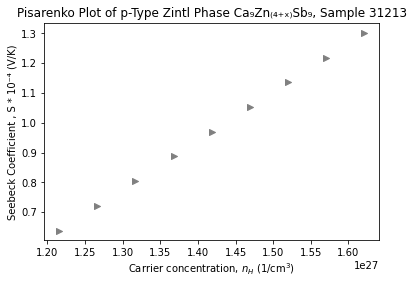

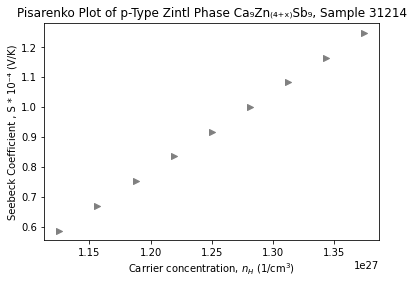

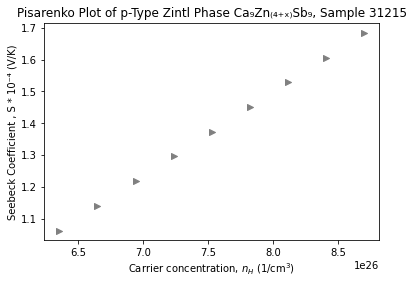

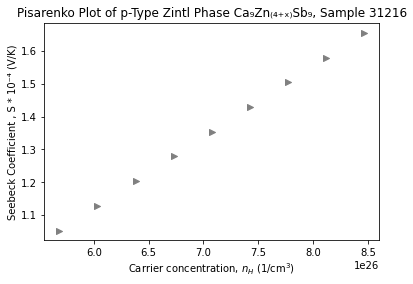

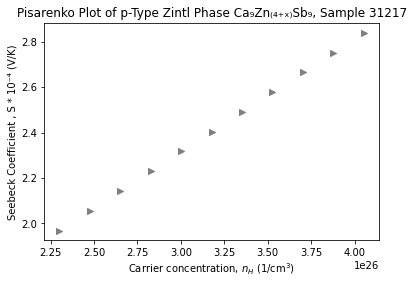

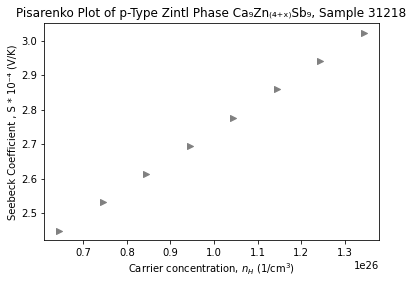

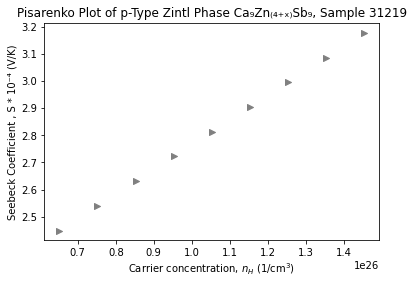

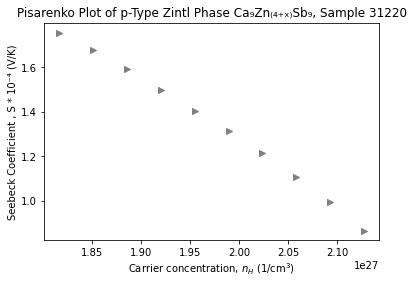

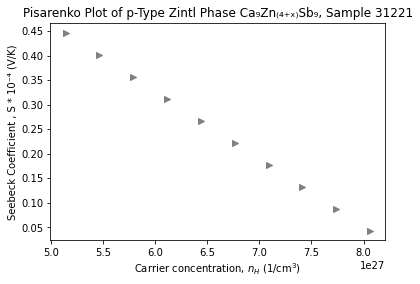

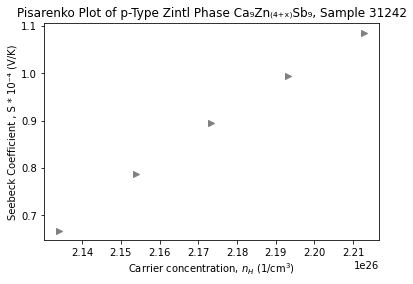

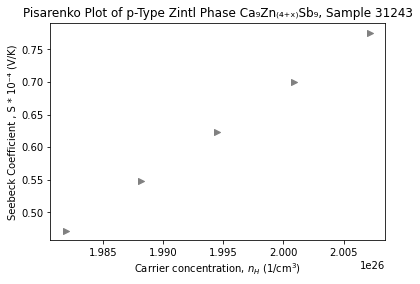

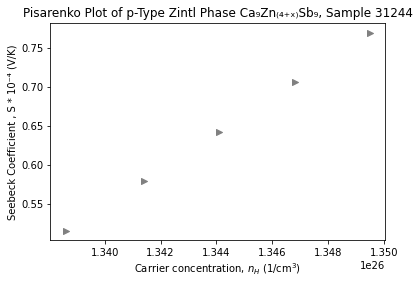

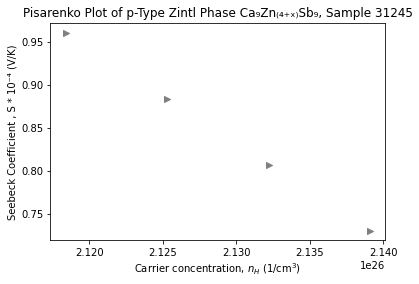

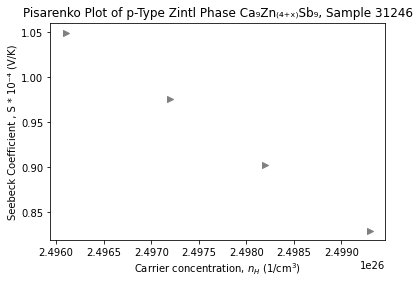

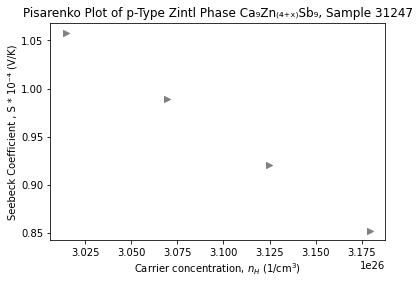

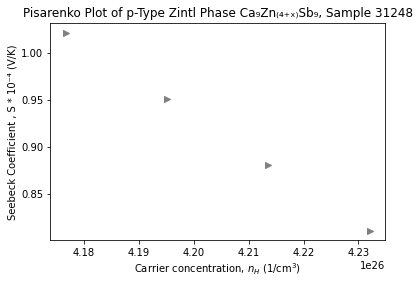

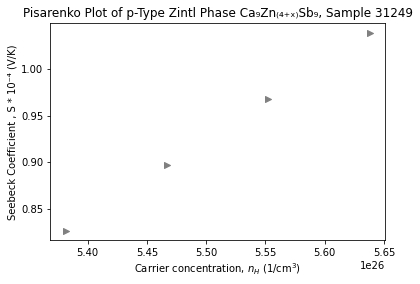

In [89]:
# Pisarenko Plots 
# S dec w/ nH dec cuz metal becomes more metallic 
# carr conc inc w/ T, S dec w/ T 
'''
Added by Ramya: Get list of sample IDs in the new_data
Note: be careful not to name variables "list" because this is
a keyword in Python that shouldn't be overwritten
'''
sid_list = list(new_data.keys()) #To understand this syntax, look up "python dictionaries"
T_list = new_data[sid_list[0]]['Temperature'].to_numpy()
print(T_list)
for i in sid_list: 
    x10 = new_data[i]['Carrier concentration'].to_numpy() #units of V/K
    y10 = new_data[i]['Seebeck coefficient'].to_numpy() * 1e4 #units of Ohm*m
    plt.figure()
    plt.scatter(x10, y10, marker = '>', color = 'grey')
    plt.ylabel('Seebeck Coefficient , S * 10⁻⁴ (V/K)')
    plt.xlabel('Carrier concentration, $n_H$ (1/cm$^3$)')
    plt.title('Pisarenko Plot of p-Type Zintl Phase Ca₉Zn₍₄₊ₓ₎Sb₉, Sample {}'.format(i))
   
# grab interploated data
# Ca Zn Sb compare 
# upwards slope weird - nh inc, S dec ()
# mult S in mV/K, mult by 1e6

undefined


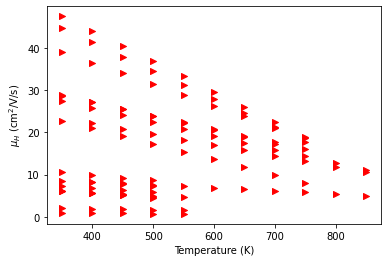

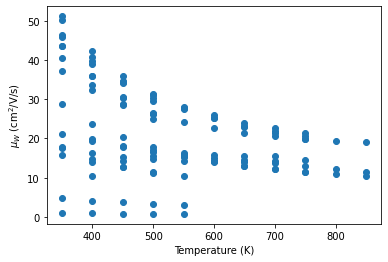

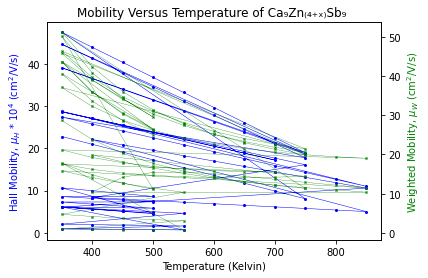

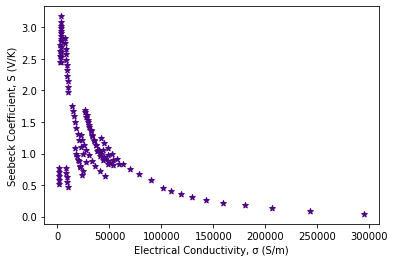

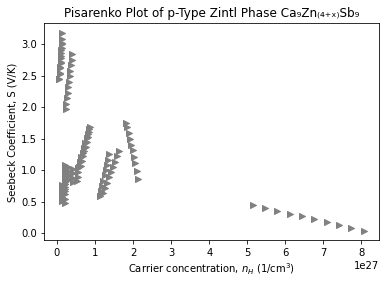

In [90]:
if __name__ == '__main__':
    #Provide path to the .csv file exported from sTarryData2
    full_df = read_STD2('csvfiles/Ca_ptype.csv')
    #Dropping all rows that don't contain mobility data in either "Carrier mobility" or "Hall movility"
    if 'Hall movility' not in full_df.columns:
        full_df['Hall movility'] = np.nan #ad column of empty values
    elif 'Carrier mobility' not in full_df.columns:
        full_df['Carrier mobility'] = np.nan #ad column of empty values
    if 'Carrier concentration' not in full_df.columns:
        full_df['Carrier concentration'] = np.nan #ad column of empty values
    hall_df = full_df.dropna(how = 'all', subset = ['Hall movility','Carrier mobility', 'Carrier concentration'])
    #Drop any rows that don't contain both Seebeck and Conductivity data too
    hall_df = hall_df.dropna(how = 'any', subset = ['Seebeck coefficient', 'Electrical resistivity'])
    #Merge Hall mobility data from different columns
    hall_df = merge_Hallmobility_columns(hall_df)
    hall_df = convert_hall_data(hall_df)
    composition = hall_df['composition'][hall_df.index[0]] #Choosing first composition with Hall mobility data
    #Print composition
    print(composition)
    #Get dataframe for just the composition of interest
    comp_df = reduced_df_by_sample(hall_df, composition)
    #Add weighted mobility data
    comp_df = add_weighted_mobility(comp_df)
    #Plots of weighted mobility and Hall mobility
    plot_mobility(comp_df)
    # call effective mass, in terms of mass by e- (divide)
    comp_df = add_effective_mass(comp_df)
    mean = comp_df['Seebeck Effective Mass'].mean()
    #print(mean)
    stdev = comp_df['Seebeck Effective Mass'].std()
    #print(stdev)
    #print(comp_df['Seebeck Effective Mass'])
    new_data = split_sampleid(comp_df)

['31213', '31214', '31215', '31216', '31217', '31218', '31219', '31220', '31221', '31242', '31243', '31244', '31245', '31246', '31247', '31248', '31249']


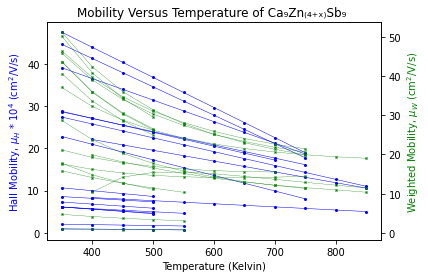

In [91]:
#old
# Weighted Mobility Plots (double axes)

#colors 

items = list(new_data.keys())
print(items)
darkcol = ['firebrick', 'orange', 'green', 'navy', 'purple' ]
lightcol = ['red', 'yellow', 'lime', 'cyan', 'magenta']
fig, ax4 = plt.subplots()
ax5 = ax4.twinx()

for i in items: 
    x = new_data[i]['Temperature'].to_numpy()
    a = new_data[i]['Carrier mobility'].to_numpy() *1e4
    b = new_data[i]['Weighted mobility'].to_numpy() 

    ax4.plot(x, a, 'blue', marker = 'o', linewidth=0.5, markersize=2)
    ax5.plot(x, b, 'green', marker = 'x', linewidth = 0.3, markersize=2)

    ax4.set_xlabel('Temperature (Kelvin)')
    ax4.set_ylabel('Hall Mobility, $\mu_H$ * 10$^4$ (cm$^2$/V/s)', color = 'blue')
    ax5.set_ylabel('Weighted Mobility, $\mu_W$ (cm$^2$/V/s) ', color = 'green')
    plt.title('Mobility Versus Temperature of Ca₉Zn₍₄₊ₓ₎Sb₉ ')
plt.show()
    
# hall are warm colors
# weighted are cold 
# send plots for comments
# check trends, read paper (linearity)

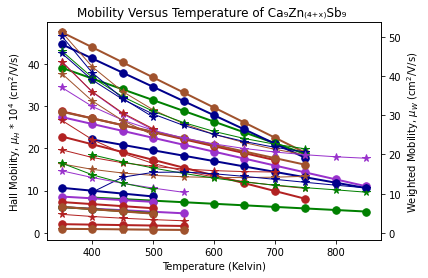

In [92]:
# Weighted Mobility Plots (double axes)

#colors 
items = list(new_data.keys())
darkcol = ['firebrick', 'sienna', 'green', 'darkblue', 'darkorchid' ]
lightcol = ['salmon', 'tan', 'greenyellow', 'lightskyblue', 'thistle']
fig, ax4 = plt.subplots()
ax5 = ax4.twinx()

for i in range(len(items)): #range() function is quite useful for looping through the indices of a list
    x = new_data[items[i]]['Temperature'].to_numpy()
    a = new_data[items[i]]['Carrier mobility'].to_numpy() *1e4
    b = new_data[items[i]]['Weighted mobility'].to_numpy() 
    ax4.plot(x, a, darkcol[i % len(darkcol)], marker = 'o', linewidth = 2, markersize = 7.5) #May repeat colors
    ax5.plot(x, b, darkcol[i % len(darkcol)], marker = '*', linewidth = 1, markersize = 7.5)

    ax4.set_xlabel('Temperature (Kelvin)')
    ax4.set_ylabel('Hall Mobility, $\mu_H$ * 10$^4$ (cm$^2$/V/s)', color = 'black')
    ax5.set_ylabel('Weighted Mobility, $\mu_W$ (cm$^2$/V/s) ', color = 'black')
    plt.title('Mobility Versus Temperature of Ca₉Zn₍₄₊ₓ₎Sb₉ ')
plt.show()
    
# hall are warm colors
# weighted are cold 
# send plots for comments
# check trends, read paper (linearity)
# hall linear
#weighted curved 

In [93]:
#Revised Pisarenko Plots

#List of temperatures where there is data
T_array = new_data[sid_list[0]]['Temperature'].to_numpy()
index_list = list(new_data[sid_list[0]]['Temperature'].index)
print(T_array)
print(index_list)
'''
Create new dictionary with this structure:

'T' : {'n': [list of carrier concentrations], 'S': [list of Seebeck values]}
'''
prenko_dict = {}

for T in T_array:
    n = [] #carrier concentration
    S = [] #Seebeck coefficient
    Smass = [] #Seebeck effective mass
    for k in new_data.keys(): #This is looping through all the sampleIDs in new_data
        indx_list = new_data[k].index
        indx = indx_list[new_data[k]['Temperature'] == T]
        try:
            n.append(float(new_data[k]['Carrier concentration'][indx]))
            S.append(float(new_data[k]['Seebeck coefficient'][indx]))
            Smass.append(float(new_data[k]['Seebeck Effective Mass'][indx]))
        except:
            continue
    prenko_dict[str(T)] = {}
    prenko_dict[str(T)]['Carrier concentration'] = n
    prenko_dict[str(T)]['Seebeck coefficient'] = S
    prenko_dict[str(T)]['Seebeck Effective Mass'] = Smass

[350 400 450 500 550 600 650 700 750]
[0, 1, 2, 3, 4, 5, 6, 7, 8]


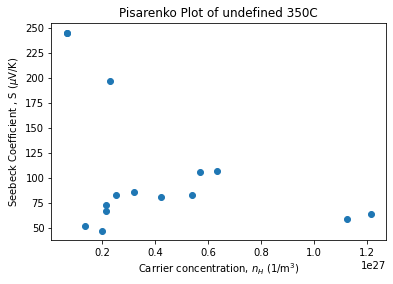

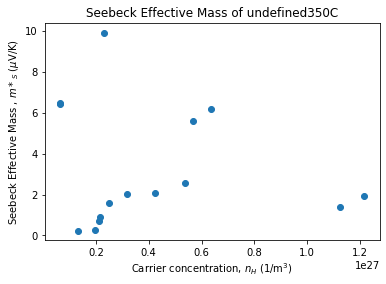

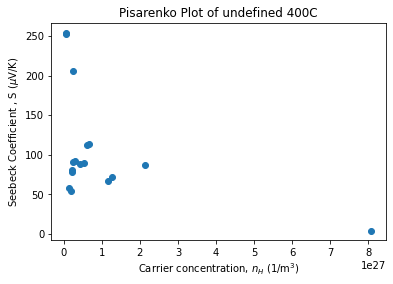

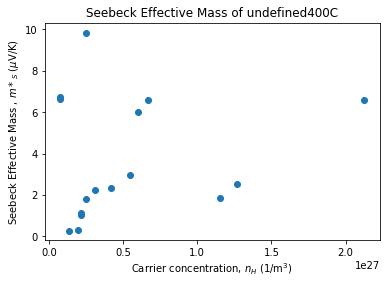

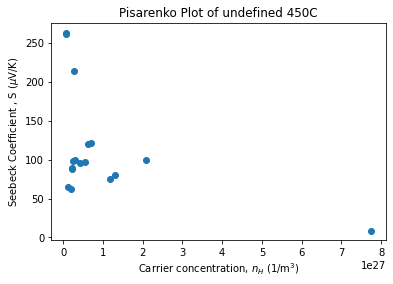

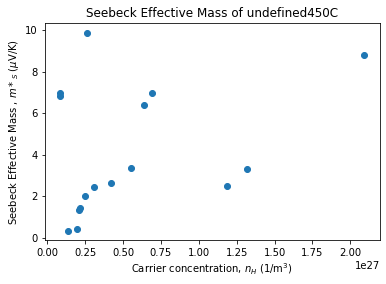

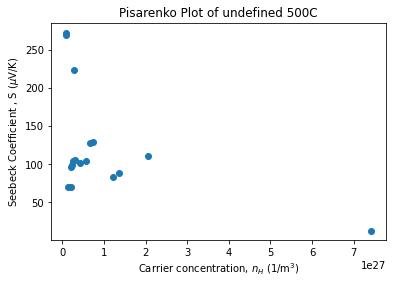

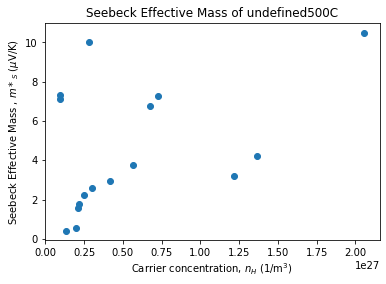

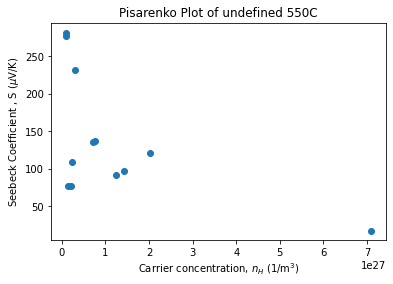

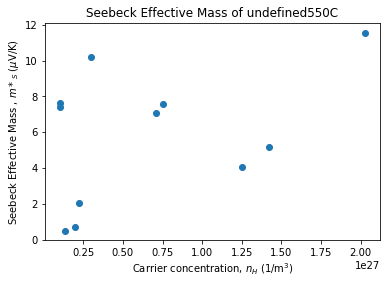

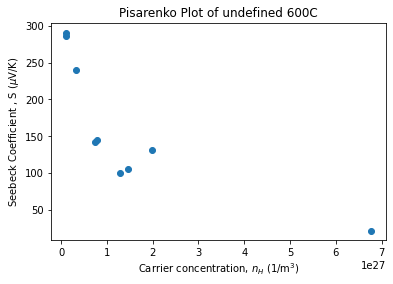

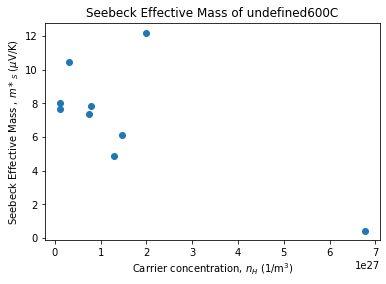

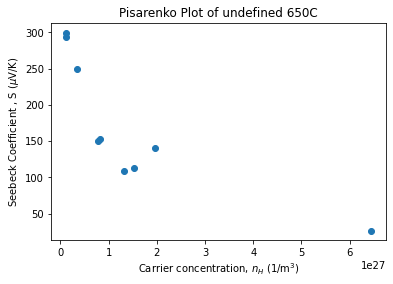

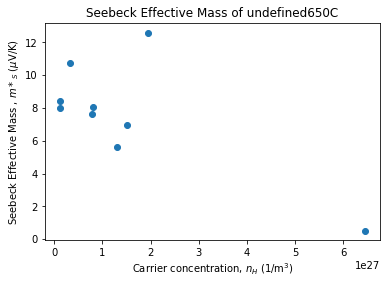

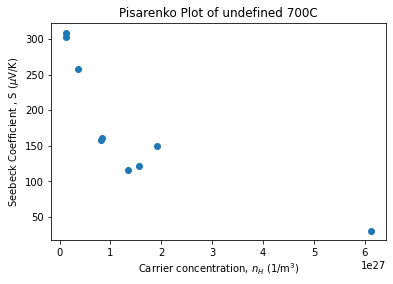

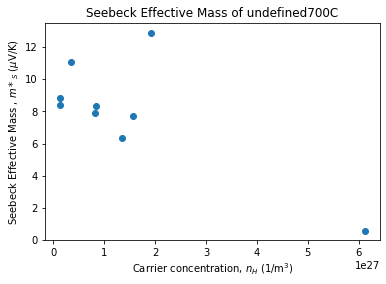

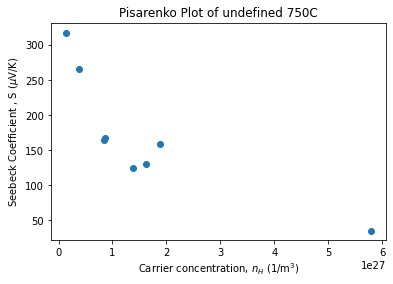

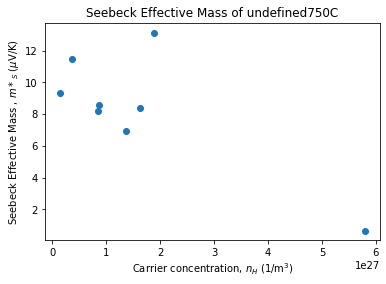

In [94]:
# Plot Updated Pisarenkos

for k in prenko_dict.keys():
    plt.ylabel(r'Seebeck Coefficient , S ($\mu$V/K)')
    plt.xlabel('Carrier concentration, $n_H$ (1/m$^3$)')
    plt.title('Pisarenko Plot of ' + composition + ' ' + k + 'C') #update composition; do proper string formatting
    # Plots of Seebeck versus carrier concentration for each temperature
    plt.scatter(prenko_dict[k]['Carrier concentration'], np.array(prenko_dict[k]['Seebeck coefficient']) * 1e6)
    plt.show()
    #Plots of Seebeck eff. mass versus carrier concentration for each temperature
    plt.ylabel(r'Seebeck Effective Mass , $m*_S$ ($\mu$V/K)')
    plt.xlabel('Carrier concentration, $n_H$ (1/m$^3$)')
    plt.title('Seebeck Effective Mass of ' + composition + k + 'C')     
    plt.scatter(prenko_dict[k]['Carrier concentration'], prenko_dict[k]['Seebeck Effective Mass'])    
    plt.show()


In [95]:
# effective mass calcs
x = np.arange(31213, 31222)
i = 0
arr = []
arr1 = np.array([])
z = 0
arr2 = np.array([])
arr3 = np.array([])

# while loop to get 3 separate arrays 
while i < len(x):
    # temperature array
    out1a = out1
    out1 = new_data[str(x[i])]['Temperature'].to_numpy()
    arr1 = np.append(arr1,out1)
    arr1 = np.append(arr1,out1a)
    # carrier conc array
    out2a = out2
    out2 = new_data[str(x[i])]['Carrier concentration'].to_numpy()
    arr2 = np.append(arr2,out2)
    arr2 = np.append(arr2,out2a)
    # S coeff array
    out3a = out3
    out3 = new_data[str(x[i])]['Seebeck Effective Mass'].to_numpy()
    arr3 = np.append(arr3,out3)
    arr3 = np.append(arr3,out3a)
    i = i + 1



NameError: name 'out1' is not defined

In [ ]:
#z = new_data['31213']['Seebeck Effective Mass'].to_numpy() #units of V/K
#print(z)

# Effective Mass Plots

#colors 
nums = [ 1, 2, 3, 4, 5] 
items = list(new_data.keys())
darkcol = ['firebrick', 'sienna', 'green', 'darkblue', 'darkorchid' ]
lightcol = ['salmon', 'tan', 'greenyellow', 'lightskyblue', 'thistle']
fig, ax4 = plt.subplots()
ax5 = ax4.twinx()

for i in range(len(items)): 
    x = new_data[items[i]]['Temperature'].to_numpy()
    a = new_data[items[i]]['Carrier mobility'].to_numpy() *1e4
    b = new_data[items[i]]['Weighted mobility'].to_numpy() 

    ax4.plot(x, a, darkcol[i], marker = 'o', linewidth = 2, markersize = 7.5)
    ax5.plot(x, b, darkcol[i], marker = '*', linewidth = 1, markersize = 7.5)

    ax4.set_xlabel('Temperature (Kelvin)')
    ax4.set_ylabel('Hall Mobility, $\mu_H$ * 10$^4$ (cm$^2$/V/s)', color = 'black')
    ax5.set_ylabel('Weighted Mobility, $\mu_W$ (cm$^2$/V/s) ', color = 'black')
    plt.title('Mobility Versus Temperature of Ca₉Zn₍₄₊ₓ₎Sb₉ ')
plt.show()
    
# hall are warm colors
# weighted are cold 
# send plots for comments
# check trends, read paper (linearity)
# hall linear
# weighted curved 

In [ ]:
nums = [ 1, 2, 3, 4, 5] 
for i in nums: 
    
    items = ['31213', '31214', '31215', '31216', '31217']
    darkcol = ['firebrick', 'sienna', 'green', 'darkblue', 'darkorchid' ]
    lightcol = ['salmon', 'tan', 'greenyellow', 'lightskyblue', 'thistle']
    fig, ax4 = plt.subplots()
    ax5 = ax4.twinx()


    x = arr350x[i]
    a = arr350y[i]
    b = arr350ye[i] 

    ax4.plot(x, a, darkcol[i-5], marker = 'o', linewidth = 2, markersize = 7.5)
    ax5.plot(x, b, darkcol[i-5], marker = '*', linewidth = 1, markersize = 7.5)

    ax4.set_xlabel('Temperature (Kelvin)')
    ax4.set_ylabel('Hall Mobility, $\mu_H$ * 10$^4$ (cm$^2$/V/s)', color = 'black')
    ax5.set_ylabel('Weighted Mobility, $\mu_W$ (cm$^2$/V/s) ', color = 'black')
    plt.title('Mobility Versus Temperature of Ca₉Zn₍₄₊ₓ₎Sb₉ ')
plt.show()
    
# fitted effective mass plot 350 

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()



ax1.plot(arr350x, arr350y, 'blue', marker = 'o', linewidth=0.5, markersize=2)
ax2.plot(arr350x, arr350ye[:len(arr350x)], 'green', marker = 'x', linewidth = 0.3, markersize=2)

ax1.set_xlabel('Carrier concentration, $n_H$ (1/m$^3$)')
ax1.set_ylabel('Hall Mobility, $\mu_H$ * 10$^4$ (cm$^2$/V/s)', color = 'blue')
ax2.set_ylabel('Weighted Mobility, $\mu_W$ (cm$^2$/V/s) ', color = 'green')
plt.title('Mobility Versus Temperature of Ca₉Zn₍₄₊ₓ₎Sb₉ ')
plt.show()
       

In [170]:
'''
MToriyama
Delete unnecessary data
'''
def Delete_Unnecessary_Data(df):
    new_df = df.copy()
    necessary_columns = [   "sampleid", \
                            "composition", \
                            "Temperature", \
                            "Carrier concentration", \
                            "Carrier mobility", \
                            "Electrical resistivity", \
                            "Seebeck coefficient", \
                            "Weighted mobility",
                            "Seebeck Effective Mass" ]
    for column in new_df.columns:
        if column not in necessary_columns:
            new_df = new_df.drop(columns=column)
    return new_df


In [171]:
'''
MToriyama
General function to parse and clean dataframe.
What it does:
    1) Deletes any paper data that doesn't include any Hall data
    2) Completes any partial Hall data
    3) Calculates weighted mobility
    4) Calculates effective mass
Inputs:
    1) Panda dataframe
'''
def Refine_Data(raw_df):
    
    # Dropping all rows that don't contain mobility data in either "Carrier mobility" or "Hall movility"
    if 'Hall movility' not in raw_df.columns:
        raw_df['Hall movility'] = np.nan #ad column of empty values
    if 'Carrier mobility' not in raw_df.columns:
        raw_df['Carrier mobility'] = np.nan #ad column of empty values
    if 'Carrier concentration' not in raw_df.columns:
        raw_df['Carrier concentration'] = np.nan #ad column of empty values
    raw_df_with_hall = raw_df.dropna(how = 'all', subset = ['Hall movility', 'Carrier concentration'])
    raw_df_with_hall = raw_df.dropna(how = 'all', subset = ['Carrier mobility', 'Carrier concentration'])
    
    # Drop any rows that don't contain both Seebeck and Conductivity data too
    raw_df_with_hall = raw_df_with_hall.dropna(how = 'any', subset = ['Seebeck coefficient', 'Electrical resistivity'])
    
    # Merge Hall mobility data from different columns
    raw_df_with_hall = merge_Hallmobility_columns(raw_df_with_hall)
    raw_df_with_hall = convert_hall_data(raw_df_with_hall)
    
    # Add weighted mobility data
    raw_df_with_hall_WM = add_weighted_mobility(raw_df_with_hall)
    
    # call effective mass, in terms of mass by e- (divide)
    raw_df_with_hall_WM_EM = add_effective_mass(raw_df_with_hall_WM)
    
    return raw_df_with_hall_WM_EM

In [172]:
'''
MToriyama
Function that reads through CSV files in a directory
What it does:
    1) Loops through CSV files in a given directory
    2) ...
Inputs:
    1) Directory name (as a string)
'''

def Parse_CSV_Files(csv_directory_name):
    for filename in os.listdir(csv_directory_name):
        if '.csv' not in filename:
            continue
        df = read_STD2(csv_directory_name+'/'+filename)
        refined_df = Delete_Unnecessary_Data( Refine_Data(df) ) # Optional, makes debugging easier


# For example:
Parse_CSV_Files('csvfiles')


Ag_ntype.csv
    sampleid composition  Temperature  Carrier concentration  \
0      31533   undefined        350.0                    NaN   
1      31533   undefined        400.0                    NaN   
2      31533   undefined        450.0                    NaN   
3      31533   undefined        500.0                    NaN   
4      31533   undefined        550.0                    NaN   
5      31533   undefined        600.0                    NaN   
6      31533   undefined        650.0                    NaN   
9      31534   undefined        350.0                    NaN   
10     31534   undefined        400.0                    NaN   
11     31534   undefined        450.0                    NaN   
12     31534   undefined        500.0                    NaN   
13     31534   undefined        550.0                    NaN   
14     31534   undefined        600.0                    NaN   
15     31534   undefined        650.0                    NaN   
16     31534   undefined   

<ipython-input-100-d0c79a4f2dc9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df['Carrier mobility'][j] = comp_df['Hall movility'][j]
<ipython-input-100-d0c79a4f2dc9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df['Carrier mobility'][j] = comp_df['Hall movility'][j]
<ipython-input-100-d0c79a4f2dc9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df['Carrier mobility'][j] = comp_df['Hall movility'][j]


     sampleid  composition  Temperature  Carrier concentration  \
0       13630  Cu2.95SbSe4          350           2.173600e+43   
1       13630  Cu2.95SbSe4          400           7.810600e+43   
2       13630  Cu2.95SbSe4          450           1.344800e+44   
3       13630  Cu2.95SbSe4          500           1.908500e+44   
4       13630  Cu2.95SbSe4          550           2.472200e+44   
..        ...          ...          ...                    ...   
119     31554    undefined          600           1.588600e+27   
120     31554    undefined          650           1.712100e+27   
121     31554    undefined          700           1.835600e+27   
122     31554    undefined          750           1.959100e+27   
123     31554    undefined          800           2.082600e+27   

     Electrical resistivity  Seebeck coefficient  Carrier mobility  \
0                  0.000222             0.000385          0.008906   
1                  0.000203             0.000370          0.007346 

/root/miniconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-100-d0c79a4f2dc9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df['Carrier mobility'][j] = comp_df['Hall movility'][j]


      sampleid                     composition  Temperature  \
869      31719              Pb0.9875Sb0.0125Te          350   
870      31719              Pb0.9875Sb0.0125Te          400   
871      31719              Pb0.9875Sb0.0125Te          450   
872      31719              Pb0.9875Sb0.0125Te          500   
873      31719              Pb0.9875Sb0.0125Te          550   
...        ...                             ...          ...   
1099     31781   In0.0050Pb0.9950Te0.996I0.004          550   
1100     31781   In0.0050Pb0.9950Te0.996I0.004          600   
1101     31781   In0.0050Pb0.9950Te0.996I0.004          650   
1102     31781   In0.0050Pb0.9950Te0.996I0.004          700   
1103     31781   In0.0050Pb0.9950Te0.996I0.004          750   

      Carrier concentration  Carrier mobility  Electrical resistivity  \
869                     NaN          0.043140                0.000006   
870                     NaN          0.038516                0.000007   
871                     

<ipython-input-100-d0c79a4f2dc9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df['Carrier mobility'][j] = comp_df['Hall movility'][j]
<ipython-input-100-d0c79a4f2dc9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df['Carrier mobility'][j] = comp_df['Hall movility'][j]
<ipython-input-100-d0c79a4f2dc9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df['Carrier mobility'][j] = comp_df['Hall movility'][j]


      sampleid composition  Temperature  Carrier concentration  \
1         7213         SnS        400.0          -4.433100e+22   
2         7213         SnS        450.0           1.871300e+22   
3         7213         SnS        500.0           8.175700e+22   
4         7213         SnS        550.0           1.448000e+23   
5         7213         SnS        600.0           2.078500e+23   
...        ...         ...          ...                    ...   
3612     31755   undefined        650.0                    NaN   
3613     31755   undefined        700.0                    NaN   
3614     31755   undefined        750.0                    NaN   
3615     31755   undefined        800.0                    NaN   
3616     31755   undefined        850.0                    NaN   

      Electrical resistivity  Seebeck coefficient  Carrier mobility  \
1                  -0.002850             0.000509          0.000863   
2                   0.000083             0.000521          0.0009

<ipython-input-100-d0c79a4f2dc9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df['Carrier mobility'][j] = comp_df['Hall movility'][j]
